# Modelling cluster magnetic fields as Gaussian random fields

This is quite well explained by Murgia+2004; https://arxiv.org/abs/astro-ph/0406225 and the approach is first mentioned in Tribble+1991. The goal is to simulate a magnetic field $B$ that has the properties of a Gaussian random field, with some correlation function or power spectrum, and that follows the thermal electron density.



We start from the magnetic field vector potential $A$. The vector potential $A$ is modelled as a power spectrum 
\begin{equation}\label{eq:powerspectrum}
|A_k|^2 \propto k^{-\xi}
\end{equation}


This is most easily generated in Fourier space (denoted by $\tilde{A}(k)$). The three components of $\tilde{A}(k)$ are complex numbers with an amplitude and phase, where the amplitude is drawn from a Rayleigh distribution and $\phi$ is uniformly distributed between $0$ and $2\pi$. This is equivalent to generating complex entries of which the real and imaginary parts are Gaussian random numbers with mean 0 and variance given by the power spectrum in the previous equation.

The wave numbers $k$ are related to the spatial scales $\Lambda$ by
\begin{equation}
k = \frac{2\pi}{\Lambda}
\end{equation}
What's convenient is saying $N$ (the amount of pixels) = $\Lambda$ (the spatial scale), this implies that we cover 64 kpc if we use 64 pixels.


Because the magnetic field is a real quantity, the following symmetry must hold:
\begin{equation}
\tilde{A}(-k) = \tilde{A}^*(k),
\end{equation}
where $^*$ denotes the complex conjugate.

The magnetic field is then given by the cross product between the vector of wavenumbers and the vector potential:
\begin{equation}
\tilde{B}(\vec{k}) = i\vec{k} \times \tilde{A}(\vec{k})
\end{equation}

This allows the imposing of the property that magnetic fields are divergence free ($\nabla \times B = 0$) and isotropic. The magnetic field is then computed by means of Fourier transform, and will follow a power spectrum given by
\begin{equation}
|B_k|^2 = C_n^2 k^{-n}
\end{equation}
where $C_n^2$ is a normalisation factor and $n=\xi-2$. 










The power spectrum of B represents then the energy on different spatial scales

This process leads to a magnetic field that has x,y,z components ($B_i$)that are Gaussian distributed, with mean zero and variance equal to 
\begin{equation}
\sigma_B^2 = <B_i^2>
\end{equation}
That means that the distribution of $B$ is a Maxwellian distribution. 

Parseval's theorem implies conservation of energy in Fourier transform:
\begin{equation}
\int |B_i|^2 dV = \int |B_k|^2 d^3 k,
\end{equation}
such that the magnetic field energy density averaged over the volume is proportional to
\begin{equation}
\begin{cases}
\begin{split}
<B>^2 & \propto \frac{C_n^2}{V} \cdot \ln(k_\mathrm{max}/k_\mathrm{min}) & \mathrm{\, for \,n=3} \\
<B>^2 & \propto \frac{C_n^2}{V} \cdot \frac{k^{3-n}_\mathrm{max} - k^{3-n}_\mathrm{min}}{3-n} & \mathrm{\, for \,n \neq 3} \\
\end{split}
\end{cases}
\end{equation}
    






The normalisation is set such that the magnetic field strength approximately follows an assumed magnetic field profile. Often, it is assumed that the magnetic field profile is proportional to the gas density profile
\begin{equation}
B(r) = <B_0> \left(\frac{n_e(r)}{n_e(0)}\right)^\eta,
\end{equation}
where $B_0$ is the average magnetic field strength at the cluster center, $n_e$ is the thermal electron gas density profile (which we have from X-rays) and $\eta$ denotes the proportionality between the magnetic field strength and electron density. (We might expect that $B^2 \propto n_e$, if the magnetic field energy density scales as the thermal gas density).


Often this operation is done in the real space, for computational efficiency, but it would be better to do it as a convolution in Fourier space before the cross product, because the normalisation kills the null-divergence property of the magnetic field. However, multiple papers have already stated that this effect is negligible when the core radius is comparable to the size of the simulated grid.

Then again, Seta+2022 state that they use a Helmholtz decomposition to ensure the divergence-free nature of the magnetic field. Might be worth looking into.


In [1]:
import sys, os
import numpy as np
import pyfftw

from astropy.io import fits
from astropy.table import Table, Column, hstack, vstack
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy.optimize import curve_fit
from scipy import stats

import argparse

# Some performance things
import gc
import multiprocessing as mp
import psutil


import matplotlib.pyplot as plt

pid = os.getpid()
python_process = psutil.Process(pid)

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [2]:
def model_xi(k, xi, N, Lambda_max=None, indices=True, Lambda_min=None):
    """
    Evaluate a given powerlaw Pk ~ k^-xi 
    With possible maximum spatial scale Lambda_max given in kpc

    The maximum scale is defined as the magnetic field reversal scale,
    see footnote in Murgia+2004. In this way, Lambda = 0.5* 2*np.pi/k 
    Thus the smallest possible k mode (k=1) always corresponds to Lambda=(N*pixsize)/2
    e.g., Lambda_max = 512 kpc for N=1024 and p=1
    Thus the next k mode (k=2) corresponds to 256 kpc and k=2 to 128 kpc etc..

    indices -- boolean -- whether 'k' (the 'k-modes') are given as indices or as values
    """

    if Lambda_max is None and Lambda_min is None: # scale invariant. Easy.
        return k**-xi
    else:
        result = k**-xi
        
            
        if Lambda_max is not None:
            # The wave mode that corresponds to the given Lambda_max in kpc
            #### Following Murgia definition that Lambda is the half-wavelength = 0.5*(2pi/k)
            kmax = np.pi/Lambda_max  
            # The index of the wave mode that corresponds to the given Lambda max in kpc
            k_index_max = (N*pixsize/2) / Lambda_max
            # Because the Gaussian_random_field function uses indices, indices
            # are given to this function, so we should mask on index length
            if indices:
                result[k<k_index_max] = 0
            else: # Mask all k modes that are smaller than kmax, corresponds to larger than Lambda_max
                result[k<kmax] = 0
                
        if Lambda_min is not None:
            kmin = np.pi/Lambda_min
            k_index_min = (N*pixsize/2) / Lambda_min
            # Because the Gaussian_random_field function uses indices, indices
            # are given to this function, so we should mask on index length
            if indices:
                result[k>k_index_min] = 0
            else: # Mask all k modes that are larger than kmin, corresponds to smaller than Lambda_min
                result[k>kmin] = 0
                            
        return result

def kvector(N,ndim, pixsize=1):
    """
    Generate ( N(xN)xN//2+1) ndim matrix of k vector values
    Since we need to do the IFFT of k cross A
    we also need this kvector array
    """
    dk = ftype(2*np.pi/N/pixsize)
    # Frequency terms, positive frequencies up unto half of the array
    # Nyquist frequency at position N//2, then negative frequencies up to -1
    ks = np.array(np.concatenate([np.arange(0, N//2+1),np.arange(-N//2+1,0)]),dtype=ftype)
    ks *= dk
                
    # My implementation of the c_field has a different definition
    # for the x axis than numpy, thus swap y and x from np.meshgrid
    if ndim == 2:
        # every particle has a 2D position
        kvector = np.zeros((N,N//2+1,ndim),dtype=ftype)
        # simply replaces more of the same for loops
        ky, kx = np.meshgrid(ks,ks) # construct a grid
        kvector[:,:,0] = kx[:,:N//2+1]
        kvector[:,:,1] = ky[:,:N//2+1]
    elif ndim == 3:
        # every particle has a 3D position. Only need half of the cube?
        kvector = np.zeros((N,N,N//2+1,ndim),dtype=ftype)
        ky, kx, kz = np.meshgrid(ks,ks,ks)
        kvector[:,:,:,0] = kx[:,:,:N//2+1]
        kvector[:,:,:,1] = ky[:,:,:N//2+1]
        kvector[:,:,:,2] = kz[:,:,:N//2+1]

    return kvector

def kvector_lengthonly(N):
    """
    Get the normalised length of the fft indices in 3D

    Only half of the cube is generated. Other half is redundant
    """

    kxkykz = np.zeros((N,N,N//2+1,3),dtype=ftype)
    indices = fftIndgen(N)
    ky, kx, kz = np.meshgrid(indices,indices,indices)
    kxkykz[:,:,:,0] = kx[:,:,:N//2+1] # only half of the 3rd axis
    kxkykz[:,:,:,1] = ky[:,:,:N//2+1] # only half of the 3rd axis
    kxkykz[:,:,:,2] = kz[:,:,:N//2+1] # only half of the 3rd axis
    # Power spectrum only depends on the length
    k_length = np.linalg.norm(kxkykz,axis=-1)

    return k_length

def kvector_lengthonly_2D(N):
    """
    Get the normalised length of the fft indices in 2D (e.g. for the RM field)

    Only half of the cube is generated. Other half is redundant for a real field
    """

    kxky = np.zeros((N,N//2+1,2),dtype=ftype)
    indices = fftIndgen(N)
    ky, kx = np.meshgrid(indices,indices)
    kxky[:,:,0] = kx[:,:N//2+1] # only half of the 3rd axis
    kxky[:,:,1] = ky[:,:N//2+1] # only half of the 3rd axis
    # Power spectrum only depends on the length
    k_length = np.linalg.norm(kxky,axis=-1)

    return k_length

def xvector(N,ndim,pixsize=1.0, subcube=False):
    """
    Generate NxN(xN)xndim matrix of x vector values
    
    This is simply a vector that goes from -31 to 32 because the real space has
    no origin before I set the origin. So xvec[31,N//2-1,N//2-1] is the origin

    if subcube -- Because its symmetric, only need a small part of cube (only positive quadrant)
    """
    xs = np.arange(-N//2+1,N//2+1,dtype=ftype)*pixsize # aranged vector of x positions
                
    # My implementation of the field has a different definition
    # for the x axis than numpy, thus swap y and x from np.meshgrid
    if ndim == 2:
        # every particle has a 2D position
        xvector = np.zeros((N,N,ndim),dtype=ftype)
        # simply replaces more of the same for loops
        y, x = np.meshgrid(xs,xs) # construct a grid
        xvector[:,:,0] = x
        xvector[:,:,1] = y
    elif ndim == 3:

        if not subcube:
            # every particle has a 3D position
            xvector = np.zeros((N,N,N,ndim),dtype=ftype)
            y, x, z = np.meshgrid(xs,xs,xs)
            xvector[:,:,:,0] = x
            xvector[:,:,:,1] = y
            xvector[:,:,:,2] = z

        else:
            # Use radial symmetry to only get  1/N^ndim of the cube
            # Only implemented for ndim==3, so 1/8th of the cube
            xvector = np.zeros((N//2+1,N//2+1,N//2+1,ndim),dtype=ftype)
            y, x, z = np.meshgrid(xs,xs,xs)
            xvector[:,:,:,0] = x[N//2-1:,N//2-1:,N//2-1:] # start from 0, omit negative part
            xvector[:,:,:,1] = y[N//2-1:,N//2-1:,N//2-1:]
            xvector[:,:,:,2] = z[N//2-1:,N//2-1:,N//2-1:]

            # e.g. for N=6 
            # x now contains [0,1,2,3]
            # instead of [-2,1,0,1,2,3]

    return xvector

def xvector_length(N, ndim, pixsize=1.0, subcube=False):
    """
    Call the function above and then compute only the length
    """
    # Now runs from -31 to +32 which is 64 values. Or 0 to +32 when subcube=True
    xvec = xvector(N, ndim, pixsize, subcube)
    # The norm of the position vector
    xvec_length = np.linalg.norm(xvec,axis=-1)
    return xvec_length

def cube_from_subcube(subcube, cubeshape):
    """
    This function can be used to compute big models more efficiently.
    
    Using radial symmetry to fill in the rest of the cube 

    if cubeshape is N then we assume (N,N,N), then subcube should be of shape (N//2+1,N//2+1,N//2+1)
    assuming that the symmetry (0) axis is the first index and the final index doesnt have to be flipped
    (i.e. also assuming that N == even)
    """
    N = cubeshape
    cube = np.zeros((N,N,N),dtype=ftype)

    ### Fill 8 subcubes by flipping across the negative axis
    # all 'negative' axis directions
    cube[:N//2-1,:N//2-1,:N//2-1] = np.flip(subcube[1:N//2,1:N//2,1:N//2])
    # 'positive' x direction, negative others
    cube[N//2-1:,:N//2-1,:N//2-1] = np.flip(subcube[0:,1:N//2,1:N//2],axis=(1,2))
    # 'positive' y direction, negative others
    cube[:N//2-1,N//2-1:,:N//2-1] = np.flip(subcube[1:N//2,0:,1:N//2],axis=(0,2))
    # 'positive' z direction, negative others
    cube[:N//2-1,:N//2-1,N//2-1:] = np.flip(subcube[1:N//2,1:N//2,0:],axis=(0,1))
    # positive x, positive y, negative z
    cube[N//2-1:,N//2-1:,:N//2-1] = np.flip(subcube[0:,0:,1:N//2],axis=(2))
    # positive x, negative y, positive z
    cube[N//2-1:,:N//2-1,N//2-1:] = np.flip(subcube[0:,1:N//2,0:],axis=(1))
    # negative x, positive y, positive z
    cube[:N//2-1,N//2-1:,N//2-1:] = np.flip(subcube[1:N//2,0:,0:],axis=(0))
    # all positive
    cube[N//2-1:,N//2-1:,N//2-1:] = subcube[0:,0:,0:]

    return cube

def radial_profile(data, center):
    """
    Calculate radial profile of array 'data', given the center 'center'
    """
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int32)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    radius = np.arange(0,np.max(r)+1) # in pixels. This is how np.bincount bins.

    return radius, radialprofile 

def fftIndgen(n):
    a = list(range(0, n//2+1))
    b = list(range(1, n//2))
    b.reverse()
    b = [-i for i in b]
    return a + b

def gaussian_random_field3D(N, Pk, k_length=None):
    """
    Adapted from http://andrewwalker.github.io/statefultransitions/post/gaussian-fields/

    Is actually nicely explained by https://garrettgoon.com/gaussian-fields/
    """
    if int(sys.version[0]) >= 3:
        ## Use fft for real values. Try to avoid copying to save memory
        run_fftw = pyfftw.builders.rfftn(np.random.normal(size = (N,N,N)).astype(ftype)
            , auto_contiguous=False, auto_align_input=False, avoid_copy=True,threads=48)
        noise = run_fftw()
    else:
        print("WARNING, USING PYTHON2. Recommended to use python3")
        noise = pyfftw.interfaces.scipy_fftpack.fftn(np.random.normal(size = (N,N,N) ).astype(ftype))

    if k_length is None:
        print ("WARNING. When calling gaussian_random_field multiple times. Recommended to give k_length")
        k_length = kvector_lengthonly(N)

    amplitude = np.sqrt(Pk(k_length))
    amplitude[0,0,0] = 0 # assume k=0 is on 0,0,0
    
    field = noise * amplitude
    return field

def magnetic_field_crossproduct(kvec, field):
    """
    Do the cross product of i*k and A(k), keeping in mind complex conjugate symmetries.

    Way faster than the old method that used loops, but only tested for even amount of N.
    And a bit more complex/obscure in the implementation. But gives exactly
    the same results as the loop method. 

    In the case that N=even (say 64)
    the complex conjugate symmetry is destroyed by the cross product
    because for index 32, the value of k_vec = pi but for -32 it's also pi. 
    But it should be -pi to keep complex conjugate symmetry. 
    # But -pi is pi in the Fourier plane because it flips there. 
    
    So it goes wrong in (64*63 - 64) cases, because that's how many points you can
    find in 3 dimensions where the coordinate on one axis is 32. 
    
    We can fix this by just doing the cross product in the half of the Fourier cube
    and taking the complex conjugate, just like how we determined the Field. 
    """
    
    fourier_B_field = np.zeros((N,N,N//2+1,3),dtype=ctype)
    # The fourier frequencies are different for (un)even N
    Neven = N%2 # add one to loops if N is uneven.
    # ONLY TESTED FOR EVEN N
                
    # all kz modes, all ky modes, half of the fourier cube, thus z=1 to N//2 (because z=0 and z//2 are special)
    fourier_B_field[:,:,1:N//2+Neven] = np.cross(1j*kvec[:,:,1:N//2+Neven], field[:,:,1:N//2+Neven],axis=-1)
                
    if Neven == 0:
        # We have an even amount of N, so do not forget the j = N//2
        # plane. It's conjugate symmetry is special because -N//2 = N//2
        # Similarly, the j=0 plane is also conjugate symmetric in the y-axis
        
        
        # We can generate half of this plane, since it's symmetric in the y axis
        # and then impose symmetry on the plane itself.
        # This is the equivalent to generating a 2D plane density field
                
        # The z=N//2 plane
        z = N//2
        # all kz modes, but start on kx at i=1 and end at N//2, because those two axes are special
        fourier_B_field[1:N//2,:,z] = np.cross(1j*kvec[1:N//2,:,z], field[1:N//2,:,z],axis=-1)      
        # The other half of the plane, complex conjugate symmetric (Hermitian symmetric)
        # Careful to also np.roll(1) in the np.flip, since otherwise we adjust the z=0 axis
        # e.g. for N=6 kx=[0, 1, 2, 3,-2,-1], so np.flip gives [-1,-2,3,2,1,0] and np.roll(flip) gives
        #                 [0,-1,-2, 3, 2, 1] as we want.
        # So for a 2D array, in this case we roll over the axis that is length N (axis=1 in this case)
        fourier_B_field[N//2+1:,:,z] = np.conj(np.roll(np.flip(fourier_B_field[1:N//2,:,z],axis=(0,1)),1,axis=1))    

        # The z=0 plane
        z = 0
        # all kz modes, but start on kx at i=1 and end at N//2, because those two axes are special
        fourier_B_field[1:N//2,:,z] = np.cross(1j*kvec[1:N//2,:,z], field[1:N//2,:,z],axis=-1)      
        # The other half of the plane, complex conjugate symmetric (Hermitian symmetric)
        fourier_B_field[N//2+1:,:,z] = np.conj(np.roll(np.flip(fourier_B_field[1:N//2,:,z],axis=(0,1)),1,axis=1))    
        

        # Don't forget the x=N//2 column, which we can generate half for
        # ky modes up to half (N//2)
        fourier_B_field[N//2,:N//2,N//2] = np.cross(1j*kvec[N//2,:N//2,N//2], field[N//2,:N//2,N//2],axis=-1)       
        # The other half is complex conjugate. Don't have to roll here, because only 1 axis
        fourier_B_field[N//2,N//2+1:,N//2] = np.conj(np.flip(fourier_B_field[N//2,1:N//2,N//2],axis=0)) 

        # And the x=0 column 
        fourier_B_field[0,:N//2,N//2] = np.cross(1j*kvec[0,N//2,:N//2], field[0,N//2,:N//2],axis=-1)       
        # The other half is complex conjugate
        fourier_B_field[0,N//2+1:,N//2] = np.conj(np.flip(fourier_B_field[0,1:N//2,N//2],axis=0)) 
        
        # same for when kz=0. Do the x=N//2 column
        fourier_B_field[N//2,:N//2,0] = np.cross(1j*kvec[N//2,:N//2,0], field[N//2,:N//2,0],axis=-1)       
        # The other half is complex conjugate
        fourier_B_field[N//2,N//2+1:,0] = np.conj(np.flip(fourier_B_field[N//2,1:N//2,0],axis=0)) 
        
        # And the kz=0, x=0 column, which we can also generate half for. 
        fourier_B_field[0,:N//2,0] = np.cross(1j*kvec[0,:N//2,0], field[0,:N//2,0],axis=-1)
        # The other half is complex conjugate
        fourier_B_field[0,N//2+1:,0] = np.conj(np.flip(fourier_B_field[0,1:N//2,0],axis=0)) 
                    
                
        # Now some numbers are their own complex conjugate.
        # i.e., they are real.
        fourier_B_field[0, 0, N//2] = fourier_B_field[0,0,N//2].real
        fourier_B_field[0, N//2, 0] = fourier_B_field[0,N//2,0].real
        fourier_B_field[N//2, 0, 0] = fourier_B_field[N//2, 0, 0].real
        
        fourier_B_field[0, N//2, N//2] = fourier_B_field[0,N//2,N//2].real
        fourier_B_field[N//2, N//2, 0] = fourier_B_field[N//2,N//2,0].real
        fourier_B_field[N//2, 0, N//2] = fourier_B_field[N//2, 0, N//2].real
        
        fourier_B_field[N//2, N//2, N//2] = fourier_B_field[N//2, N//2, N//2].real
        
    # Don't forget that the [0,0] component of the field has to be 0
    fourier_B_field[0,0,0] = 0 + 1j*0   
    
    # Now we don't have to generate the modes in the other half of the Fourier cube
    # because it's a redundant part, so we can just use irfftn    
    
    return fourier_B_field

def polynomial(x, A, B, C):
    '''
    a second order polynomial function:
    f(x,y) = A * x ** 2  + B * x ** 2 + C
     
    x       -- numpy array containing x coordinates
    A, B, C -- coefficients
    '''
    return A * x ** 2  + B * x + C

def normalise_Bfield(ne_3d, ne0, B_field, eta, B0, xvec_length, subcube=False):
    """
    Normalise the B field such that it follows the electron density profile

    ne_3d   -- electron density at every point in the 3D space. shape (N,N,N)
    ne0     -- electron density in the center of the cluster
    B_field -- Magnetic field at every point in the 3D space. shape (N,N,N,3)
    eta     -- Proportionality of B to n_e
    B0      -- Mean magnetic field in center
    xvec_length -- vector defining the radius wrt the center of the image in (N,N,N)
    subcube -- Because its symmetric, only need a small part of cube (only positive quadrant)

    """
    B_field_amplitude = np.linalg.norm(B_field,axis=3)

    all_r, profile = radial_profile(B_field_amplitude[:,:,N//2-1], center=[N//2-1,N//2-1])
    all_r *= np.int32(pixsize)

    # Fit a polynomial to the radial profile of the B field such that
    # we can get a normalised profile
    popt, _ = curve_fit(polynomial, all_r, profile)
    # Evaluate the polynomial at every radius
    average_profile = polynomial(xvec_length, *popt)

    if subcube:
        # make the full cubes for the normalisation of the B field
        # Expand 1/8th of the cube to the full cube. 
        ne_3d = cube_from_subcube(ne_3d, N)
        average_profile = cube_from_subcube(average_profile, N)

    # Normalise the B field to mean 1*B0 and then multiply by the normalised profile
    B_field_norm = B_field/average_profile.reshape(N,N,N,1)* B0 * (np.power(ne_3d / ne0, eta)).reshape(N,N,N,1)
    # Special case, central point
    c = N//2-1
    # Make sure B field is B0 muGauss in center
    B_field_norm[c,c,c] = B0/np.sqrt(3) # so it's a 3D vector with length 1*B0, in a particular direction

    return B_field_norm, ne_3d

def RM(n_e,B_field,pixsize,axis):
    """
    Calculate Rotation measure by integrating over a certain axis
    (Riemann sum)
    
    Integrating over one pixel is integration over pixsize*1000 parsecs.
    """
    return 0.81*pixsize*1e3*np.sum(n_e*B_field[:,:,:,axis],axis=axis)

def calc_phi_obs(phi_intrinsic, RM, wavelength):
    """
    Calculate observed polarisation angle at a certain wavelength
    Given the intrinsic polarisation angle and the rotation measure
    """
    phi_obs = (phi_intrinsic + RM * wavelength**2) % (2*np.pi)
    return phi_obs 

def StokesQU_image(phi_obs, polint_intrinsic):
    """
    Calculate the Stokes Q and U flux given the intrinsic polarised intensity 
    and the polarisation angle
    """
    Q = polint_intrinsic / np.sqrt(1+np.tan(2*phi_obs)**2)
    
    U = np.sqrt(polint_intrinsic**2 - Q**2)
    
    # Positive Q for angle between -pi/2 and pi/2
    # which in our definition is angle > 3/2 pi or < 1/2 pi
    # Thus negative Q for angles between 1/2pi and 3/2 pi
    negQ = np.bitwise_and(np.pi/2 <= phi_obs, phi_obs <= 3*np.pi/2)
    Q[negQ] *= -1
    
    # Negative U for angles larger than pi
    negU = phi_obs > np.pi 
    U[negU] *= -1
    
    return Q, U

def convolve_with_beam(images, FWHM, pixsize=1.0):
    """
    Convolve the images with a (circular) Gaussian beam with FWHM given in kpc,
    which is equal to the amount of pixels if 1 pixel is 1 kpc
    """
    print ("Convolving with a beam FHWM of %i kpc"%FWHM)

    # FWHM to standard deviation divided by pixel size 
    std = FWHM/(2*np.sqrt(2*np.log(2))) / pixsize

    print ("Which is a standard deviation of %i pixels"%std)

    if std < 2:
        print ("Since the beam resolution (FHWM %.1f kpc or std %.1f kpc) is so close to the simulated resolution (%.1f kpc), NOT smoothing"%(FWHM,std*pixsize, pixsize))
        return images 

    beam = Gaussian2DKernel(std)
    convolved = []
    for image in images:
        convolved.append(convolve(image,beam,boundary='extend',normalize_kernel=True))
    return convolved

def columndensity(n_e, pixsize, axis):
    """
    We can calculate the column density image by integrating over a certain axis (Riemann sum)
    pixels are given in kpc, so we should convert that to cm
    """
    kpc = 3.08567758e21 #centimeters
    return pixsize*kpc*np.sum(n_e,axis=axis)

def beta_model(r, ne0=0.0031, r_c=341, beta=0.77):
    """
    Use beta model with Remi Adam's parameters
    
    r    -- float or array -- radius in kpc [kpc] 
    ne0  -- float  -- central electron density in cm^-3
    r_c  -- float  -- core radius in kpc
    beta -- float  -- beta parameter
    
    """    
    return ne0 * (1+(r/r_c)**2)**(-3*beta/2)

# For power spectra calculation
# A nice explanation is given by
# https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/
def checkpowerspectrum(Fourierfield): 
    """
    Given a 2D Fourier field which is NOT shifted to have the k-mode 0 in the centre, 
    calculate the power spectrum. 
    """
    field_shift = np.fft.fftshift(Fourierfield)
    field_shift = np.absolute(field_shift)**2 # Calculate amplitude of Fourier components

    plt.title("log10(Fourier amplitudes) with k=0 in centre.")
    plt.imshow(np.log10(field_shift))
    plt.colorbar()
    plt.show()

    # Calculate the radial profile around the center (which is now the zero k-mode)
    center = (field_shift.shape[0]//2,field_shift.shape[1]//2)
    all_k, Power_spectrum = radial_profile(field_shift/(2*np.pi)**2, center)

    amplitude = Power_spectrum[1]
    alpha = xi-2
    theoretical = amplitude*np.asarray(all_k,dtype='float')**-alpha
    # start at 1 because k = 0, Power = 0
    plt.plot(all_k[1:],Power_spectrum[1:],label='data')
    plt.plot(all_k[1:], theoretical[1:]
        ,label='Pk = %.1f k**-%.1f'%(amplitude,alpha), ls='dashed')
    plt.xlabel('k')
    plt.ylabel('P(k)')
    plt.title('Power spectrum inferred')
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.show()

def shell_averaged_power_spectrum(field, component='total', multiply_volume=False):
    """
    # Assuming the input cube 'field' is the Fourier field with dimensions e.g. (512, 512, 256, 3)
    # so it has to be conjugate symmetric. 
    # assuming it's not FFT shifted, so kx=0 is at index=0 instead of the centre
    """
    nx, ny, nz, _ = field.shape

    if component == 'total':
        # Compute the squared magnitude of the field strength (i.e. |Bx,By,Bz| )
        power_spectrum = np.linalg.norm(np.abs(field)**2, axis=-1)  # shape (512, 512, 256)
    elif component == 'x':
        # Compute the squared magnitude of the Bx component only
        power_spectrum = (np.abs(field[:,:,:,0])**2)  # shape (512, 512, 256)
    elif component == 'y':
        # Compute the squared magnitude of the By component only
        power_spectrum = (np.abs(field[:,:,:,1])**2)  # shape (512, 512, 256)        
    elif component == 'z':
        # Compute the squared magnitude of the Bz component only
        power_spectrum = (np.abs(field[:,:,:,2])**2)  # shape (512, 512, 256)        

    # Create the wavenumber grid (half of the cube)
    k_magnitude = kvector_lengthonly(nx) # assumes nx=ny=nz

    # Flatten the k_magnitude and power_spectrum arrays
    k_magnitude = k_magnitude.ravel()
    power_spectrum = power_spectrum.ravel()

    # Define the bins for shell averaging
    k_max = nx//2+1 # only have good sampling in k up to nx//2
                    # although k_max is technically sqrt(Ndim)*nx//2
                    # then we would be sampling outside the image because the 'circle' is too large
    k_bins = np.arange(0.5, k_max + 1.5, 1.0)
    # Compute the corresponding k values for the shell-averaged power spectrum
    k_values = 0.5 * (k_bins[1:] + k_bins[:-1])

    # Bin the power spectrum values based on the wavenumber magnitude
    Abins, _, _ = stats.binned_statistic(k_magnitude, power_spectrum,
                                         statistic = "mean", # statistic = sum
                                         bins = k_bins)

    # Multiply by the volume to go from 3D to 1D power spectrum
    if multiply_volume:
        # if 2D field (see below)
        # Abins *= np.pi * (k_bins[1:]**2 - k_bins[:-1]**2)  # in 2D volume (area) is pi r^2
        
        # if 3D field (default)
        Abins *= 4. * np.pi / 3. * (k_bins[1:]**3 - k_bins[:-1]**3)  # in 3D volume is 4/3 pi r^3

    return k_values, Abins

def shell_averaged_power_spectrum2D(field, multiply_volume=False):
    """
    # Assuming the input cube 'field' is the Fourier field with dimensions e.g. (512, 256)
    # so it has to be conjugate symmetric. 
    # assuming it's not FFT shifted, so kx=0 is at index=0 instead of the centre
    """
    nx, ny = field.shape

    # Compute the squared magnitude 
    power_spectrum = np.abs(field)**2  # shape (512, 256)

    # Create the wavenumber grid (half of the cube)
    k_magnitude = kvector_lengthonly_2D(nx) # assumes nx=ny=nz

    # Flatten the k_magnitude and power_spectrum arrays
    k_magnitude = k_magnitude.ravel()
    power_spectrum = power_spectrum.ravel()

    # Define the bins for shell averaging
    k_max = nx//2+1 # only have good sampling in k up to nx//2
                    # although k_max is technically sqrt(Ndim)*nx//2
                    # then we would be sampling outside the image because the 'circle' is too large
    k_bins = np.arange(0.5, k_max + 1.5, 1.0)
    # Compute the corresponding k values for the shell-averaged power spectrum
    k_values = 0.5 * (k_bins[1:] + k_bins[:-1])

    # Bin the power spectrum values based on the wavenumber magnitude
    Abins, _, _ = stats.binned_statistic(k_magnitude, power_spectrum,
                                         statistic = "mean", # statistic = sum
                                         bins = k_bins)

    # Multiply by the volume to go from 2D to 1D power spectrum
    if multiply_volume:
        # if 2D field
        Abins *= np.pi * (k_bins[1:]**2 - k_bins[:-1]**2)  # in 2D volume (area) is pi r^2
        
        # if 3D field (see function above)
        # Abins *= 4. * np.pi / 3. * (k_bins[1:]**3 - k_bins[:-1]**3)  # in 3D volume is 4/3 pi r^3

    return k_values, Abins

#### Set parameters:

In [3]:
xi = 3+2 # n=3 case
N = 512 # this rapidly increases memory requirements (N^3)
eta = 0.5 # B field density proportionality
B0 = 5.0
Lambda_max = None # Max fluctuation scale unconstrained
Lambda_min = None #30 # Min fluctuation scale 30 kpc
pixsize = 3 # 1 pix = this many kpc
ftype = np.float32 # Using 32 bits to save memory
ctype = np.complex64 # same 
garbagecollect = True # also for saving memory

## 1. Generate magnetic field from a vector potential A

In [4]:
# The powerlaw Pk ~ k^-xi
Peff = lambda k: model_xi(k, xi, N, Lambda_max, indices=True)

# Make field without the redundant Fourier components
# (i.e. because the field is real, the Fourier transformation is symmetric)
field = np.zeros((N,N,N//2+1,3),dtype=ftype) + 1j*np.zeros((N,N,N//2+1,3),dtype=ftype)

# Get the normalised index length in 3D space
k_length = kvector_lengthonly(N)

print ("Random field x-dimension..")
field[:,:,:,0] = gaussian_random_field3D(N, Peff, k_length)
print ("Random field y-dimension..")
field[:,:,:,1] = gaussian_random_field3D(N, Peff, k_length)
print ("Random field z-dimension..")
field[:,:,:,2] = gaussian_random_field3D(N, Peff, k_length)

print ("Generating k vector in (%i,%i,%i,3) space"%(N,N,N//2))
kvec = kvector(N, 3, pixsize)

print ("Calculating magnetic field using the crossproduct Equation")
# Fourier B field = Cross product  B = ik \cross A 
field = magnetic_field_crossproduct(kvec, field)
del kvec # Huge array which we dont need anymore 

if garbagecollect: 
    print ("Deleted kvec. Collecting garbage..")
    gc.collect()
    memoryUse = python_process.memory_info()[0]/2.**30
    print('Memory used: %.1f GB'%memoryUse)

Random field x-dimension..


/tmp/ipykernel_2756037/2566851293.py:16: RuntimeWarning: divide by zero encountered in power
  return k**-xi


Random field y-dimension..
Random field z-dimension..
Generating k vector in (512,512,256,3) space
Calculating magnetic field using the crossproduct Equation
Deleted kvec. Collecting garbage..
Memory used: 2.0 GB


#### We can check the power spectrum of the magnetic field to see if it indeed follows the expected index $n=\xi-2$:

Let's first just check the power spectrum of the 2D field at z=0 and Bx component (it's same for y and z component)

/tmp/ipykernel_2756037/2566851293.py:488: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(field_shift))


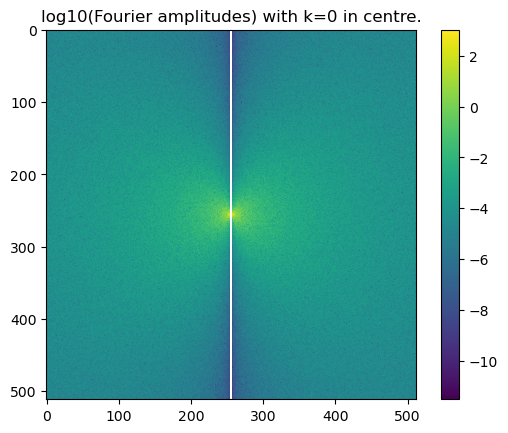

/tmp/ipykernel_2756037/2566851293.py:498: RuntimeWarning: divide by zero encountered in power
  theoretical = amplitude*np.asarray(all_k,dtype='float')**-alpha


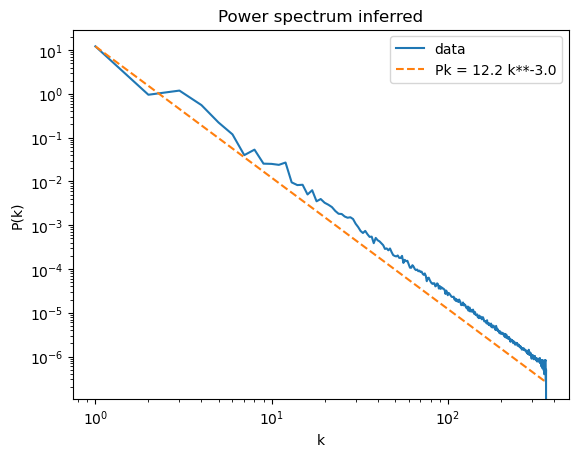

In [5]:
check = True

if check:
    checkpowerspectrum(field[:,:,0,0]) # z=0 axis, x component. (same for y and z component)

Indeed we see that the magnetic field power spectrum follows a spectral index $n=\xi-2$.



Let's also compute the power spectrum of the spatial 3D field, of the amplitude of the 3D magnetic field

In [10]:
k_values, Pk_values = shell_averaged_power_spectrum(field, component='total', multiply_volume=False)

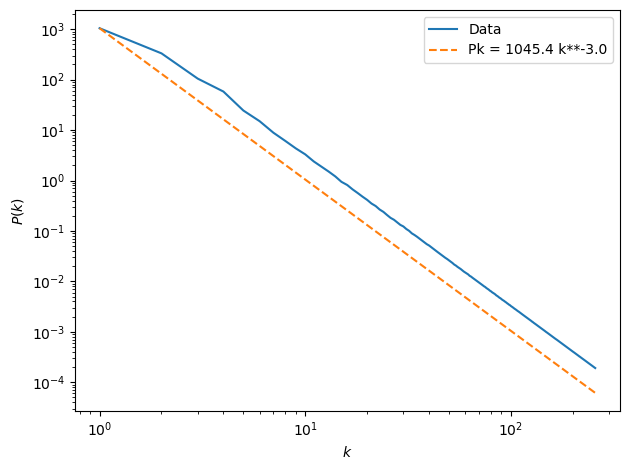

In [11]:
plt.loglog(k_values, Pk_values, label='Data')
# Compare with expectation
amplitude = Pk_values[0]
alpha = xi-2
theoretical = amplitude*np.asarray(k_values,dtype='float')**-alpha * (k_values[0]**alpha)
plt.plot(k_values, theoretical,label='Pk = %.1f k**-%.1f'%(amplitude,alpha), ls='dashed')
plt.xlabel('$k$')
plt.ylabel("$P(k)$")
plt.legend()
plt.tight_layout()
plt.show()

Indeed we see that the 3D magnetic field amplitude (but also each of the individual components) follow a power spectrum with a spectral index $n=\xi-2$.

Note that we express the power spectra as vectorial forms in k-space. The one-dimensional forms can be obtained by setting multiply_volume=True

This makes the spectrum k^(Ndim-1) flatter, thus multiplies the dimensionality by k^2 from 3D to 1D , or k^1 from 2D to 1D. 

#### Now inverse Fourier transform to get the magnetic field in real space.

In [8]:
if int(sys.version[0]) < 3:
    print("WARNING, USING PYTHON2. PLEASE RUN WITH PYTHON3")

# B field is the inverse fourier transform of fourier_B_field
run_ift = pyfftw.builders.irfftn(field,s=(N,N,N),axes=(0,1,2)
    , auto_contiguous=False, auto_align_input=False, avoid_copy=True,threads=48)
field = run_ift()
B_field = field # re-name it B-field for clarity
if garbagecollect: 
    print ("Ran IFFT. Collecting garbage..")
    gc.collect()
    memoryUse = python_process.memory_info()[0]/2.**30
    print('Memory used: %.1f GB'%memoryUse)

Ran IFFT. Collecting garbage..
Memory used: 3.5 GB


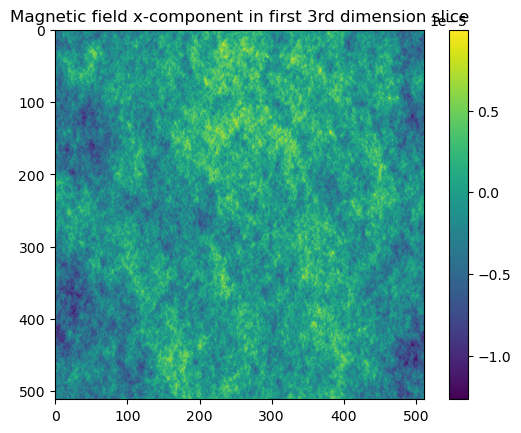

In [9]:
# B_field is now a (N,N,N,3) array which holds the xyz components of the B field 
# in all 3 dimensions
plt.imshow(B_field[:,:,0,0])
plt.title("Magnetic field x-component in first 3rd dimension slice")
plt.colorbar()
plt.show()
# It's not normalised yet

We can see some spatial correlation, as expected

## 2. Normalising the B field with an assumed density profile 

In [10]:
## Using radial symmetry in a way where we can only use 1/8th of the cube
## we can calculate ne_3d about 6x faster for N=1024
subcube = True
multiprocessing = True

# Vector denoting the real space positions. The 0 point is in the middle.
# Now runs from -31 to +32 which is 64 values for N=64. Or 0 to +32 when subcube=True
# The norm of the position vector
xvec_length = xvector_length(N, 3, pixsize, subcube=subcube)

def ne_funct(xvec_length):
    """Function that returns electron density when given radius [kpc]
    User can change with own definition or use beta model
    """
    # return 0.0031*np.ones(xvec_length.shape) # constant electron density
    return beta_model(xvec_length, ne0=0.0031, r_c=341, beta=0.77) # Abell 2256


## Calculate the density profile in a cube 
if multiprocessing:
    pool = mp.Pool(processes=8)
    ne_3d = np.asarray(pool.map(ne_funct, xvec_length))
    pool.close()
    pool.join()
else:
    ne_3d = ne_funct(xvec_length)
    
if subcube:
    c = 0 # then the center pixel is the first one, because the subcube is only the positive subset
else:
    # Make sure n_e is not infinite in the center. Just set it to the pixel next to it
    c = N//2-1; 
    
# Make sure n_e is not infinite in the center. Just set it to the pixel next to it
ne_3d[c,c,c] = ne_3d[c,c+1,c]
ne0 = ne_3d[c,c,c] # Electron density in center of cluster

# Normalise the B field such that it follows the electron density profile ^eta
B_field_norm, ne_3d = normalise_Bfield(ne_3d, ne0, B_field, eta, B0, xvec_length, subcube)

In [11]:
### Again clean up some memory    
del B_field # We dont need B field unnormalised anymore 
del xvec_length # We dont need xvec_length anymore

if garbagecollect: 
    print ("Deleted B_field and xvec_length. Collecting garbage..")
    gc.collect()
    memoryUse = python_process.memory_info()[0]/2.**30
    print('Memory used: %.1f GB'%memoryUse)

Deleted B_field and xvec_length. Collecting garbage..
Memory used: 5.5 GB


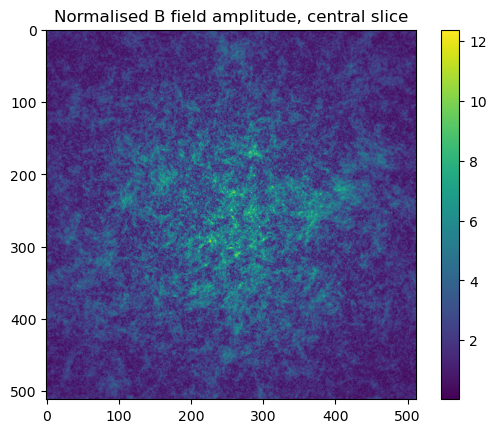

In [12]:
# Calculate the amplitude of the B field
B_field_amplitude = np.linalg.norm(B_field_norm,axis=3)
plt.imshow(B_field_amplitude[:,:,N//2])
plt.title("Normalised B field amplitude, central slice")
plt.colorbar()
plt.show()

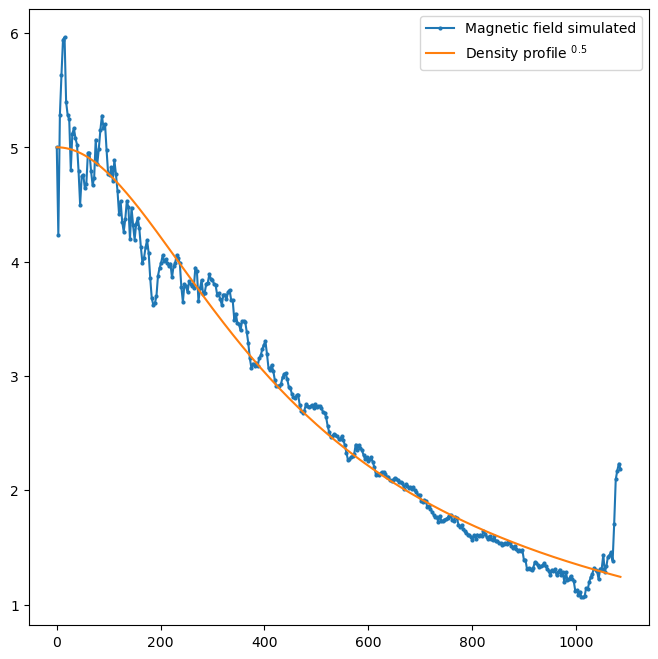

In [13]:
# Plot the profile of the central slice
all_r, profile = radial_profile(B_field_amplitude[:,:,N//2-1], center=[N//2-1,N//2-1])
all_r *= np.int32(pixsize)
fig, ax = plt.subplots(figsize=(8,8))
plt.plot(all_r,profile,label='Magnetic field simulated',marker='o',markersize=2)
# Compare with density profile
density = beta_model(all_r)
plt.plot(all_r,((density/density[0])**0.5)*B0,label='Density profile $^{0.5}$')
plt.legend()
plt.show()

We can see that the magnetic field amplitude is indeed still random, but following the assumed density profile to the assumed power $\eta$, and starting with the central field strength $B_0$.

For good measure, let's see if the power spectrum of B changed

In [14]:
## Use fft for real values. Try to avoid copying to save memory
run_fftw = pyfftw.builders.rfftn(B_field_norm
    , auto_contiguous=False, auto_align_input=False, avoid_copy=True,threads=48, axes=(0,1,2))
B_field_norm_fft = run_fftw()

In [15]:
B_field_norm.shape, B_field_norm_fft.shape

((512, 512, 512, 3), (512, 512, 257, 3))

In [16]:
k_values, Pk_values = shell_averaged_power_spectrum(B_field_norm_fft, component='total', multiply_volume=False)

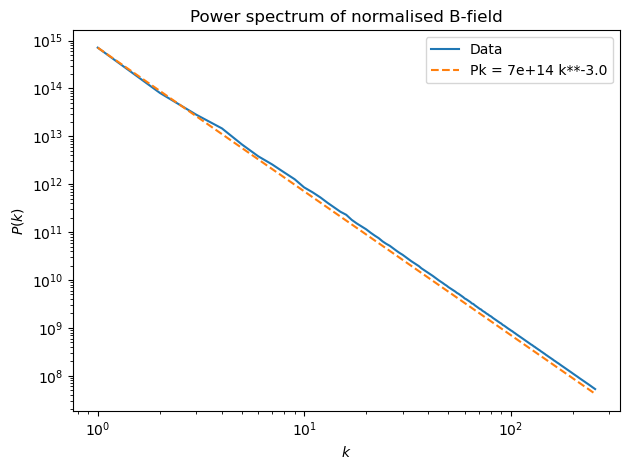

In [17]:
plt.loglog(k_values, Pk_values, label='Data')
# Compare with expectation
amplitude = Pk_values[0]
alpha = xi-2
theoretical = amplitude*np.asarray(k_values,dtype='float')**-alpha * (k_values[0]**alpha)
plt.plot(k_values, theoretical,label='Pk = %.e k**-%.1f'%(amplitude,alpha), ls='dashed')
plt.xlabel('$k$')
plt.ylabel("$P(k)$")
plt.legend()
plt.title("Power spectrum of normalised B-field")
plt.tight_layout()
plt.show()

# 3. Calculating RM and depol

\begin{equation}
\phi(\textbf{r}) = 0.81 \int n_e \textbf{B} \cdot d\textbf{r} \;\; \left[\mathrm{rad\: m}^{-2}\right],
\end{equation}

In [18]:
# Calculate the RM by integrating over the 3rd axis
RMimage = RM(ne_3d,B_field_norm,pixsize,axis=2) # shape (512,512)

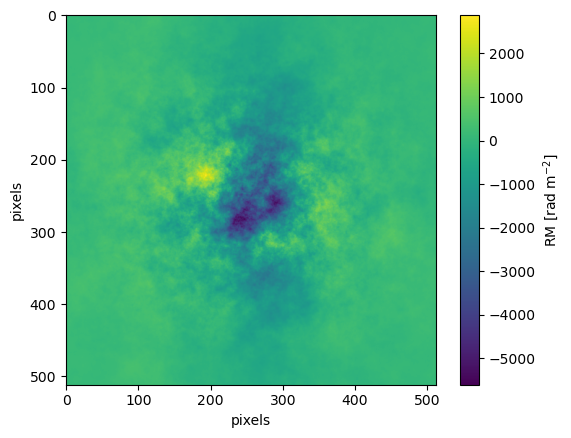

In [19]:
plt.imshow(RMimage)
cbar = plt.colorbar()
cbar.set_label("RM [rad m$^{-2}$]")
plt.xlabel("pixels")
plt.ylabel("pixels")
plt.show()

#### The RM power spectrum also follows the same spectrum as the magnetic field power spectrum. 

In [20]:
## Use fft for real values. Try to avoid copying to save memory
run_fftw = pyfftw.builders.rfftn(RMimage
    , auto_contiguous=False, auto_align_input=False, avoid_copy=True,threads=48)
RMimage_fft = run_fftw()

In [21]:
k_values, Pk_values = shell_averaged_power_spectrum2D(RMimage_fft, multiply_volume=False)

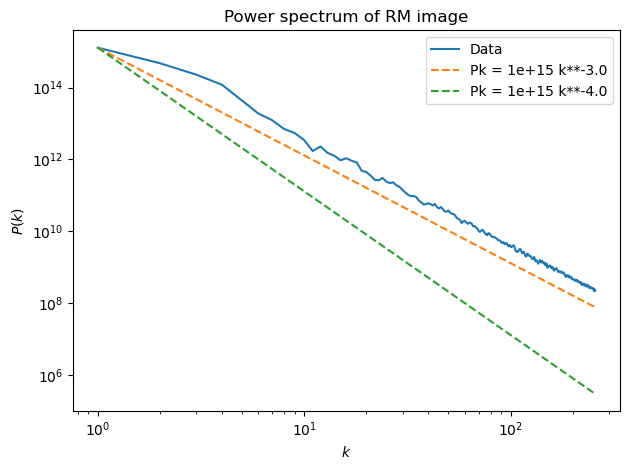

In [22]:
plt.loglog(k_values, Pk_values, label='Data')
# Compare with expectation
amplitude = Pk_values[0]
alpha = xi-2
# According to Murgia+2004
theoretical = amplitude*np.asarray(k_values,dtype='float')**-alpha * (k_values[0]**alpha)
plt.plot(k_values, theoretical,label='Pk = %.e k**-%.1f'%(amplitude,alpha), ls='dashed')
# According to Seta+2022 for a constant electron density and magnetic field strength
theoretical2 = amplitude*np.asarray(k_values,dtype='float')**(-alpha-1) * (k_values[0]**(alpha+1))
plt.plot(k_values, theoretical2,label='Pk = %.e k**-%.1f'%(amplitude,alpha+1), ls='dashed')
plt.xlabel('$k$')
plt.ylabel("$P(k)$")
plt.legend()
plt.title("Power spectrum of RM image")
plt.tight_layout()
plt.show()

### We can see that the power spectrum of the RM image follows that of the magnetic field amplitude

#### Then we can convert an assumed intrinsic polarisation and the polarisation angle to Stokes Q and U images. 

If we assume a constant intrinsic polarisation angle $\chi_0$ 
\begin{equation}
\chi_\mathrm{obs} = \chi_0 + RM \lambda^2
\end{equation}

And because we have these two equations
\begin{equation}
P = \sqrt{U^2 + Q^2} \\
\chi = \frac{1}{2} \arctan \frac{U}{Q}
\end{equation}
Which we can convert to 
\begin{equation}
Q =  \pm \sqrt{\frac{P^2}{1+\tan^2(2\chi)}} \\ 
U =  \pm \sqrt{P^2 - Q^2}.
\end{equation}
Using the convention that Stokes Q is positive for $-\pi/2 \leq \chi \leq \pi/2$ and Stokes U is positive for $0 \leq \chi < \pi$. 


In [23]:
cz = 0.175 # Assumed cluster redshift
wavelength = 0.2 # 1.5 GHz = 0.2 meters. Observed wavelength of radiation
wavelength_cluster = wavelength / (1+cz) # Wavelength at redshift of cluster
phi_intrinsic = 45*np.pi/180 # degrees to radians


# Calculate observed 
phi_obs = calc_phi_obs(phi_intrinsic, RMimage, wavelength_cluster) # Shape (N,N)

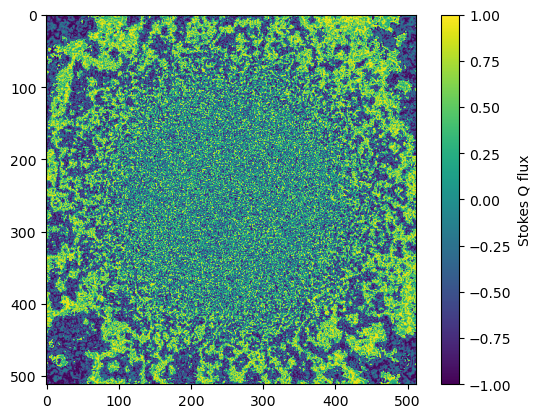

In [24]:
polint_intrinsic = 1 # Let's say 1 Jy/beam
# Use equations above to calculate Stokes Q and U 
Qflux, Uflux = StokesQU_image(phi_obs, polint_intrinsic)

plt.imshow(Qflux)
cbar = plt.colorbar()
cbar.set_label("Stokes Q flux")
plt.show()

In [25]:
# Convolve Stokes Q and U with beam, which causes depolarisation

# Calculate the resolution we have at cluster redshift with a 6 arcsec beam
beamsize = 6.0 # arcsec
resolution = (cosmo.kpc_proper_per_arcmin(cz)*beamsize*u.arcsec).to(u.kpc)
FWHM = resolution.value # in kpc
std_gausskernel = FWHM/(2*np.sqrt(2*np.log(2))) # in kpc

Qconvolved, Uconvolved = convolve_with_beam([Qflux,Uflux], FWHM, pixsize)

# Convert those to angle and pol int
polangle = np.arctan2(Uconvolved,Qconvolved)*0.5
Polint = np.sqrt(Qconvolved**2+Uconvolved**2)

Convolving with a beam FHWM of 17 kpc
Which is a standard deviation of 2 pixels


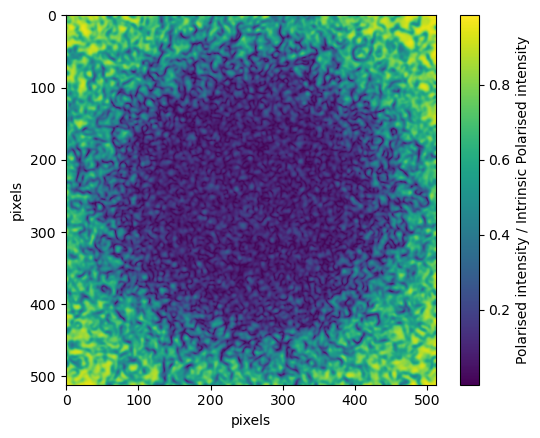

In [26]:
plt.imshow(Polint)
cbar = plt.colorbar()
cbar.set_label("Polarised intensity / Intrinsic Polarised intensity")
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.show()

Can plot the radial profile to see that depol decreases as function of distance

In [27]:
all_r, profile = radial_profile(Polint, center=[N//2-1,N//2-1])

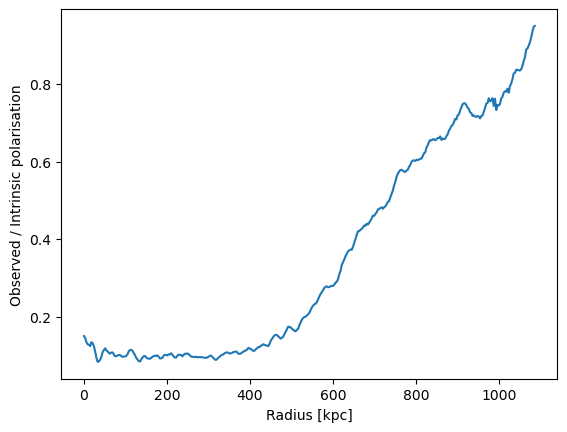

In [28]:
plt.plot(all_r*pixsize, profile)
plt.ylabel('Observed / Intrinsic polarisation')
plt.xlabel("Radius [kpc]")
plt.show()